# Risk Clustering in Portfolio Optimization
### Data Preparation

In [65]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# Date range
start = '2018-01-01'
end = '2022-12-31'

#Tickers of assets
assets = ['D:1COV','D:ADS','D:AIR','D:ALV','D:BAS',
          'D:BAYN','D:BEI','D:BMW','D:BNR','D:CON',
          'D:DB1','D:DBK','D:DPW','D:DTE','D:EOAN', 
          'D:FME','D:FRE','D:HEI','D:HEN3','D:HNR1', 
          'D:IFX','D:MBG','D:MRK','D:MTX','D:MUV2',
          'D:PAH3','D:PUM','D:QIA','D:RWE','D:SAP',
          'D:SIE','D:SRT3','D:SY1','D:VNA','D:VOW3',
          'D:ZAL']
assets.sort()

data = pd.read_excel("DAX15-22_2.xlsx", index_col=0, parse_dates=False)
data = data.loc[start:end]
data

,D:1COV,D:ADS,D:AIR,D:ALV,D:BAS,D:BAYN,D:BEI,D:BMW,D:BNR,D:CON,...,D:PUM,D:QIA,D:RWE,D:SAP,D:SIE,D:SRT3,D:SY1,D:VNA,D:VOW3,D:ZAL
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,86.25,167.35,83.41,192.179,91.800,102.223,97.881,87.061,53.166,201.717,...,36.50,26.13,17.002,93.54,104.968,80.042,71.386,38.610,166.785,44.194
2018-01-02,86.20,167.65,82.76,193.220,91.670,101.460,96.000,86.570,52.620,201.382,...,36.05,25.96,17.345,93.21,104.472,80.000,70.680,38.395,166.100,43.960
2018-01-03,86.86,168.70,84.08,193.380,92.000,101.618,96.460,87.140,52.260,205.316,...,36.30,26.55,17.430,94.21,105.808,80.100,71.080,39.164,171.500,45.100
2018-01-04,88.58,170.70,86.15,196.460,93.600,102.740,97.960,87.960,53.040,207.820,...,36.35,26.84,17.450,95.41,108.225,83.650,71.760,39.164,174.160,45.080
2018-01-05,88.38,172.15,85.79,198.000,94.670,106.774,99.300,88.370,53.220,211.755,...,36.35,26.92,17.620,96.42,108.514,83.400,73.260,39.332,178.600,45.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,36.40,125.94,111.60,202.250,46.395,48.675,106.400,83.650,59.200,56.160,...,54.44,46.64,41.580,97.53,128.820,346.800,102.650,21.850,116.000,32.660
2022-12-27,36.72,126.12,112.66,203.200,46.815,48.725,107.400,83.860,59.220,56.880,...,55.52,46.50,41.550,97.41,129.080,351.900,103.500,21.810,116.000,32.910
2022-12-28,36.96,126.00,111.60,202.350,46.665,48.475,106.750,83.280,59.780,55.820,...,55.52,46.91,41.300,96.66,128.140,355.700,102.850,22.040,115.160,32.720


In [2]:
norm_return = data/data.iloc[0]*10000

In [3]:
returns = (data/data.iloc[0]*10000).pct_change().dropna()

### Split the data set

data_train -> in-sample \
data_test -> out-of-sample

In [4]:
data_train = data.loc['2018-01-01':'2022-06-30']
data_test = data.loc['2022-07-01':'2022-12-31']

### Calculate return

In [5]:
ret = data_train.pct_change().dropna()
ret_test = data_test.pct_change().dropna()

### Calculate Covariance and Correlation

In [6]:
cov = ret.cov()
corr = ret.corr()

### Distance Correlation

In [7]:
d_corr = np.sqrt(0.5*(1-corr))

## Hierarchical Risk Parity
### 1. Hierarchical Clustering
#### Determine the linkage method

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings("ignore")

link = linkage(d_corr, 'ward')

In [9]:
def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice # calculate the inversev-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0] 
    return c_var

### 2. Quasi Diagonalization

In [10]:
def get_quasi_diag(link):
    # sort clustered items by distance
    link = link.astype(int)
    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]])
    # the total num of items is the third item of the last list
    num_items = link[-1, 3]
    # if the max of sort_ix is bigger than or equal to the max_items

    while sort_ix.max() >= num_items:
        # assign sort_ix index with 24 x 24
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2) #odd numers as index
        df0 = sort_ix[sort_ix >= num_items] # find clusters
        # df0 contain even index and cluster index
        i = df0.index
        j = df0.values - num_items #
        sort_ix[i] = link[j,0] # item 1
        df0 = pd.Series(link[j, 1], index=i+1)
        sort_ix = sort_ix.append(df0)
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    return sort_ix.tolist()

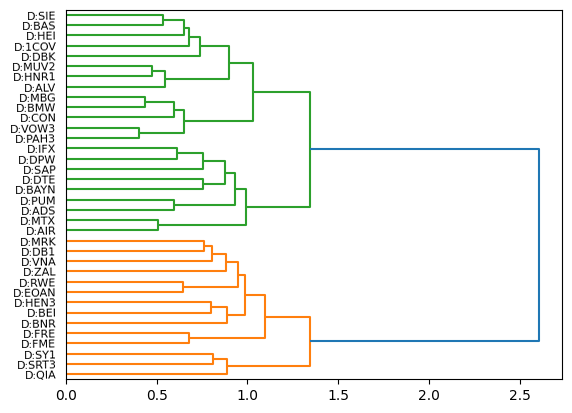

<Figure size 20000x12000 with 0 Axes>

In [11]:
assets = np.array(assets)
den = dendrogram(linkage(d_corr, 'ward', optimal_ordering=False), leaf_rotation=True, labels=d_corr.index, orientation='right')
plt.figure(figsize=(20, 12), dpi = 1000)
#plt.savefig("dendogram_ward.png", transparent=True)
plt.show()

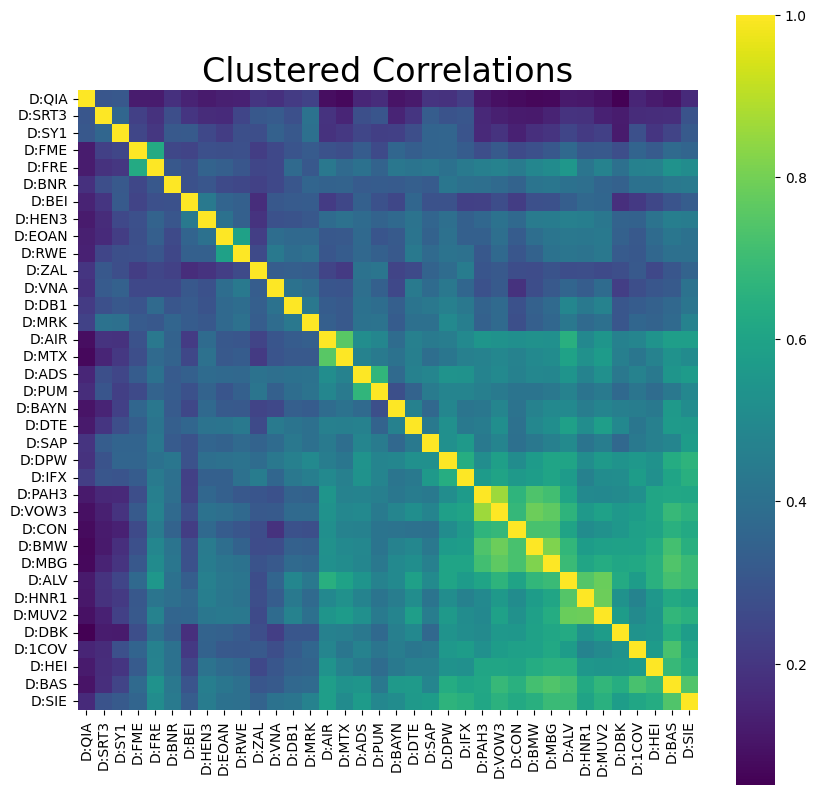

In [12]:
import seaborn as sns

sort_ix = get_quasi_diag(link)
assets = np.array(assets)
df_vis = ret[assets[sort_ix]]
corr2 = df_vis.corr()
fig = plt.figure(figsize=(10,10), dpi = 100)
bx = sns.heatmap(corr2, cmap="viridis", square=True, fmt = '.2f').set_title('Clustered Correlations', fontsize=24)

In [13]:
def get_rec_bipart(cov, sort_ix):
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)
    
    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        c_items = [i[int(j):int(k)] for i in c_items for j,k in
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1] 
    
        # now it has 2
        for i in range(0, len(c_items), 2): 
            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2 
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            alpha = 1 - c_var0/(c_var0+c_var1)
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha
    return w

In [14]:
def weight_HRP(cov,corr):
    d_corr = np.sqrt(0.5*(1-corr))
    link = linkage(d_corr, 'ward')
    sort_ix = get_quasi_diag(link)
    hrp = get_rec_bipart(cov, sort_ix)
    return hrp.sort_index()

In [15]:
HRP = weight_HRP(cov, corr)

In [16]:
new_index = [ret.columns[i] for i in HRP.index]
HRP.index = new_index
HRP.name = "HRP"
HRP

D:1COV    0.015443
D:ADS     0.014187
D:AIR     0.015256
D:ALV     0.024783
D:BAS     0.011932
D:BAYN    0.022843
D:BEI     0.074984
D:BMW     0.010967
D:BNR     0.044650
D:CON     0.006689
D:DB1     0.050629
D:DBK     0.010929
D:DPW     0.025480
D:DTE     0.049532
D:EOAN    0.045668
D:FME     0.051652
D:FRE     0.037793
D:HEI     0.018438
D:HEN3    0.042555
D:HNR1    0.020756
D:IFX     0.011366
D:MBG     0.013530
D:MRK     0.037948
D:MTX     0.014092
D:MUV2    0.019952
D:PAH3    0.012995
D:PUM     0.009985
D:QIA     0.043870
D:RWE     0.034045
D:SAP     0.027450
D:SIE     0.012564
D:SRT3    0.023250
D:SY1     0.067185
D:VNA     0.047791
D:VOW3    0.012465
D:ZAL     0.016348
Name: HRP, dtype: float64

## Mean-Variance

In [17]:
def weight_MV(cov):
    inv_covar = np.linalg.inv(cov)
    u = np.ones(len(cov))
    x = np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))
    return pd.Series(x, index = assets, name="MV")

In [18]:
MV = weight_MV(cov)
MV

D:1COV   -0.003261
D:ADS    -0.021569
D:AIR    -0.018733
D:ALV     0.047708
D:BAS     0.010807
D:BAYN    0.020139
D:BEI     0.163329
D:BMW     0.131278
D:BNR     0.052907
D:CON     0.052614
D:DB1     0.093888
D:DBK    -0.008603
D:DPW    -0.034355
D:DTE     0.176900
D:EOAN    0.149584
D:FME     0.100399
D:FRE    -0.033977
D:HEI     0.013543
D:HEN3    0.093553
D:HNR1    0.003075
D:IFX    -0.063073
D:MBG    -0.085505
D:MRK     0.024810
D:MTX    -0.027146
D:MUV2   -0.011503
D:PAH3    0.026863
D:PUM    -0.008640
D:QIA     0.117778
D:RWE    -0.053074
D:SAP     0.042271
D:SIE    -0.039419
D:SRT3   -0.012739
D:SY1     0.096176
D:VNA     0.093590
D:VOW3   -0.093414
D:ZAL     0.003800
Name: MV, dtype: float64

## Equal-Weight

In [19]:
def weight_EW(cov):
    x = [1 / len(cov) for i in range(len(cov))]
    return pd.Series(x, index = assets, name="1/N")

In [20]:
EW = weight_EW(cov)
EW

D:1COV    0.027778
D:ADS     0.027778
D:AIR     0.027778
D:ALV     0.027778
D:BAS     0.027778
D:BAYN    0.027778
D:BEI     0.027778
D:BMW     0.027778
D:BNR     0.027778
D:CON     0.027778
D:DB1     0.027778
D:DBK     0.027778
D:DPW     0.027778
D:DTE     0.027778
D:EOAN    0.027778
D:FME     0.027778
D:FRE     0.027778
D:HEI     0.027778
D:HEN3    0.027778
D:HNR1    0.027778
D:IFX     0.027778
D:MBG     0.027778
D:MRK     0.027778
D:MTX     0.027778
D:MUV2    0.027778
D:PAH3    0.027778
D:PUM     0.027778
D:QIA     0.027778
D:RWE     0.027778
D:SAP     0.027778
D:SIE     0.027778
D:SRT3    0.027778
D:SY1     0.027778
D:VNA     0.027778
D:VOW3    0.027778
D:ZAL     0.027778
Name: 1/N, dtype: float64

## Results
### Weights of Portfolio

In [21]:
weights = []
weights = HRP.to_frame()
weights = weights.join(MV.to_frame())
weights = weights.join(EW.to_frame())
weights

,HRP,MV,1/N
D:1COV,0.015443,-0.003261,0.027778
D:ADS,0.014187,-0.021569,0.027778
D:AIR,0.015256,-0.018733,0.027778
D:ALV,0.024783,0.047708,0.027778
D:BAS,0.011932,0.010807,0.027778
D:BAYN,0.022843,0.020139,0.027778
D:BEI,0.074984,0.163329,0.027778
D:BMW,0.010967,0.131278,0.027778
D:BNR,0.044650,0.052907,0.027778
D:CON,0.006689,0.052614,0.027778


### Expected Return of Portfolio

In [22]:
def portfolio_ER(weights):
    mean = ret.mean()
    return weights * mean

In [23]:
er_HRP = portfolio_ER(HRP)
er_HRP.name = "HRP"
er_MV = portfolio_ER(MV)
er_MV.name = "MV"
er_EW = portfolio_ER(EW)
er_EW.name = "1/N"
ers = er_HRP.to_frame()
ers = ers.join(er_MV.to_frame())
ers = ers.join(er_EW.to_frame())
ers = ers.sum()
ers.name = "Expected Return"
ers = ers.to_frame()
ers

,Expected Return
HRP,0.000161
MV,0.000017
1/N,0.000134


### Annual Volatility of Portfolio

In [24]:
def portfolio_volatility(weights, cov):
    return np.sqrt(np.dot(np.dot(weights, cov), weights))*np.sqrt(252)

In [25]:
volatility = [portfolio_volatility(HRP, cov)]
volatility.append(portfolio_volatility(MV, cov))
volatility.append(portfolio_volatility(EW, cov))
volatility = pd.DataFrame(data = volatility, index=["HRP", "MV", "1/N"],
columns=["Volatility"])
volatility

,Volatility
HRP,0.170336
MV,0.134235
1/N,0.201265


## Normalized Return
the daily price / the price at the beginning

In [26]:
data_train/data_train.iloc[0]

,D:1COV,D:ADS,D:AIR,D:ALV,D:BAS,D:BAYN,D:BEI,D:BMW,D:BNR,D:CON,...,D:PUM,D:QIA,D:RWE,D:SAP,D:SIE,D:SRT3,D:SY1,D:VNA,D:VOW3,D:ZAL
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-01-02,0.999420,1.001793,0.992207,1.005417,0.998584,0.992536,0.980783,0.994360,0.989730,0.998339,...,0.987671,0.993494,1.020174,0.996472,0.995275,0.999475,0.990110,0.994431,0.995893,0.994705
2018-01-03,1.007072,1.008067,1.008033,1.006249,1.002179,0.994082,0.985482,1.000907,0.982959,1.017842,...,0.994521,1.016073,1.025174,1.007163,1.008002,1.000725,0.995713,1.014349,1.028270,1.020501
2018-01-04,1.027014,1.020018,1.032850,1.022276,1.019608,1.005058,1.000807,1.010326,0.997630,1.030255,...,0.995890,1.027172,1.026350,1.019991,1.031029,1.045076,1.005239,1.014349,1.044219,1.020048
2018-01-05,1.024696,1.028682,1.028534,1.030289,1.031264,1.044520,1.014497,1.015035,1.001016,1.049763,...,0.995890,1.030233,1.036349,1.030789,1.033782,1.041953,1.026252,1.018700,1.070840,1.020501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,0.403130,1.023006,1.115694,0.947034,0.462854,0.567191,1.001420,0.862039,1.141331,0.330066,...,1.825205,1.673555,2.212093,0.989309,0.985824,4.110342,1.505197,0.833204,0.839884,0.571345
2022-06-27,0.395478,1.030415,1.116533,0.942663,0.466013,0.578735,1.005507,0.869965,1.156378,0.337106,...,1.833973,1.701110,2.170333,0.987706,0.991350,4.129082,1.491889,0.811707,0.826333,0.574286
2022-06-28,0.400812,1.021213,1.129481,0.949531,0.464107,0.587441,1.001216,0.873640,1.159388,0.351978,...,1.780274,1.709529,2.194448,0.968890,0.986015,4.162815,1.458269,0.810930,0.841682,0.566140


### Normalized Return each Method
#### In-Sample

In [27]:
train=pd.DataFrame(np.dot((data_train/data_train.iloc[0]),(weights*10000)), \
                             columns=['HRP', 'MV', '1/N'], index = data_train.index)
train

,HRP,MV,1/N
Date,,,
2018-01-01,10000.000000,10000.000000,10000.000000
2018-01-02,9960.882972,9923.848903,9972.764054
2018-01-03,10034.401633,9957.605921,10066.253485
2018-01-04,10149.124129,10020.271506,10193.986553
2018-01-05,10243.901570,10106.833260,10270.645496
...,...,...,...
2022-06-24,11523.056144,9940.713577,10922.939706
2022-06-27,11528.875569,9968.070899,10942.912242
2022-06-28,11515.858591,9925.565515,10948.034539


#### Out-of-Sample

In [28]:
test=pd.DataFrame(np.dot((data_test/data_test.iloc[0]),(weights*10000)), \
                             columns=['HRP', 'MV', '1/N'], index = data_test.index)
test

,HRP,MV,1/N
Date,,,
2022-07-01,10000.000000,10000.000000,10000.000000
2022-07-04,10014.740932,10140.233809,9963.071459
2022-07-05,9889.992425,10124.501354,9771.760824
2022-07-06,9982.224203,10242.875989,9842.494748
2022-07-07,10100.348171,10232.823182,10053.472888
...,...,...,...
2022-12-26,10235.044898,9639.694701,10495.556069
2022-12-27,10273.964340,9675.783649,10541.805790
2022-12-28,10247.563763,9679.026455,10500.630761


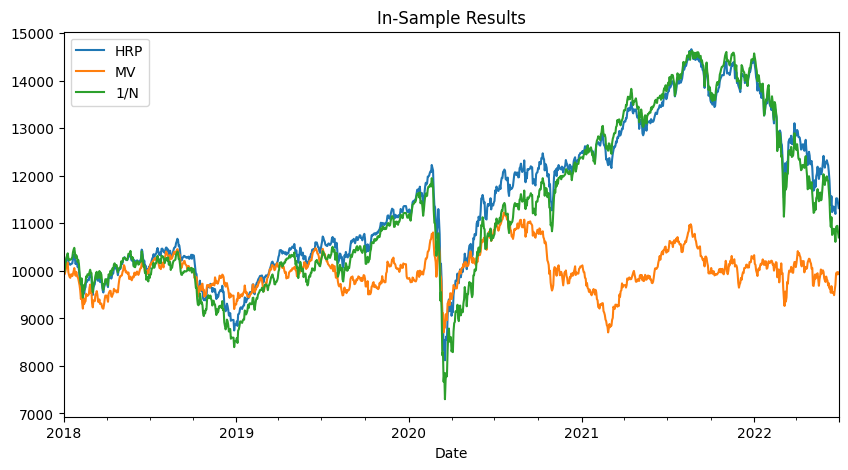

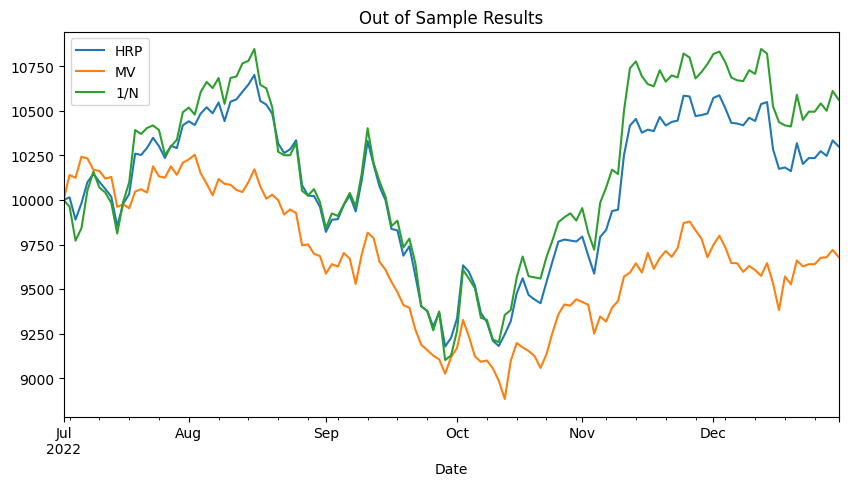

In [29]:
train.plot(figsize=(10, 5), title ='In-Sample Results')
plt.savefig("insample.png", transparent=True)
test.plot(figsize=(10, 5), title ="Out of Sample Results")
plt.savefig("outofsample.png", transparent=True)

## Add DAX Performance in Sample 
### In-Sample

In [30]:
dax = pd.read_excel("DAX65.xlsx", index_col=0, parse_dates=False)
dax = dax.loc['2018-01-01':'2022-06-30']
dax

,DAX
Date,
2018-01-01,12917.64
2018-01-02,12871.39
2018-01-03,12978.21
2018-01-04,13167.89
2018-01-05,13319.64
...,...
2022-06-24,13118.13
2022-06-27,13186.07
2022-06-28,13231.82


In [31]:
dax/dax.iloc[0]*10000

,DAX
Date,
2018-01-01,10000.000000
2018-01-02,9964.196246
2018-01-03,10046.889370
2018-01-04,10193.727337
2018-01-05,10311.202356
...,...
2022-06-24,10155.206369
2022-06-27,10207.801115
2022-06-28,10243.217801


In [32]:
train_all = train.join(dax/dax.iloc[0]*10000)
train_all

,HRP,MV,1/N,DAX
Date,,,,
2018-01-01,10000.000000,10000.000000,10000.000000,10000.000000
2018-01-02,9960.882972,9923.848903,9972.764054,9964.196246
2018-01-03,10034.401633,9957.605921,10066.253485,10046.889370
2018-01-04,10149.124129,10020.271506,10193.986553,10193.727337
2018-01-05,10243.901570,10106.833260,10270.645496,10311.202356
...,...,...,...,...
2022-06-24,11523.056144,9940.713577,10922.939706,10155.206369
2022-06-27,11528.875569,9968.070899,10942.912242,10207.801115
2022-06-28,11515.858591,9925.565515,10948.034539,10243.217801


In [33]:
return_train = train.pct_change().dropna()
return_train

,HRP,MV,1/N
Date,,,
2018-01-02,-0.003912,-0.007615,-0.002724
2018-01-03,0.007381,0.003402,0.009374
2018-01-04,0.011433,0.006293,0.012689
2018-01-05,0.009338,0.008639,0.007520
2018-01-08,0.005163,0.004216,0.005146
...,...,...,...
2022-06-24,0.028963,0.023739,0.029370
2022-06-27,0.000505,0.002752,0.001828
2022-06-28,-0.001129,-0.004264,0.000468


In [34]:
return_train_all = train_all.pct_change().dropna()
return_train_all

,HRP,MV,1/N,DAX
Date,,,,
2018-01-02,-0.003912,-0.007615,-0.002724,-0.003580
2018-01-03,0.007381,0.003402,0.009374,0.008299
2018-01-04,0.011433,0.006293,0.012689,0.014615
2018-01-05,0.009338,0.008639,0.007520,0.011524
2018-01-08,0.005163,0.004216,0.005146,0.003614
...,...,...,...,...
2022-06-24,0.028963,0.023739,0.029370,0.015918
2022-06-27,0.000505,0.002752,0.001828,0.005179
2022-06-28,-0.001129,-0.004264,0.000468,0.003470


### Out-of-Sample

In [35]:
dax_test = pd.read_excel("DAX65.xlsx", index_col=0, parse_dates=False)
dax_test = dax_test.loc['2022-07-01':'2022-12-31']
dax_test

,DAX
Date,
2022-07-01,12813.03
2022-07-04,12773.38
2022-07-05,12401.20
2022-07-06,12594.52
2022-07-07,12843.22
...,...
2022-12-26,13940.93
2022-12-27,13995.10
2022-12-28,13925.60


In [36]:
dax_test/dax_test.iloc[0]*10000

,DAX
Date,
2022-07-01,10000.000000
2022-07-04,9969.054939
2022-07-05,9678.585003
2022-07-06,9829.462664
2022-07-07,10023.561952
...,...
2022-12-26,10880.275782
2022-12-27,10922.553057
2022-12-28,10868.311399


In [37]:
test_all = test.join(dax_test/dax_test.iloc[0]*10000)
test_all

,HRP,MV,1/N,DAX
Date,,,,
2022-07-01,10000.000000,10000.000000,10000.000000,10000.000000
2022-07-04,10014.740932,10140.233809,9963.071459,9969.054939
2022-07-05,9889.992425,10124.501354,9771.760824,9678.585003
2022-07-06,9982.224203,10242.875989,9842.494748,9829.462664
2022-07-07,10100.348171,10232.823182,10053.472888,10023.561952
...,...,...,...,...
2022-12-26,10235.044898,9639.694701,10495.556069,10880.275782
2022-12-27,10273.964340,9675.783649,10541.805790,10922.553057
2022-12-28,10247.563763,9679.026455,10500.630761,10868.311399


In [39]:
return_test = test.pct_change().dropna()
return_test

,HRP,MV,1/N
Date,,,
2022-07-04,0.001474,0.014023,-0.003693
2022-07-05,-0.012456,-0.001551,-0.019202
2022-07-06,0.009326,0.011692,0.007239
2022-07-07,0.011833,-0.000981,0.021435
2022-07-08,0.004538,-0.006226,0.010462
...,...,...,...
2022-12-26,0.000000,0.000000,0.000000
2022-12-27,0.003803,0.003744,0.004407
2022-12-28,-0.002570,0.000335,-0.003906


In [40]:
return_test_all = test_all.pct_change().dropna()
return_test_all

,HRP,MV,1/N,DAX
Date,,,,
2022-07-04,0.001474,0.014023,-0.003693,-0.003095
2022-07-05,-0.012456,-0.001551,-0.019202,-0.029137
2022-07-06,0.009326,0.011692,0.007239,0.015589
2022-07-07,0.011833,-0.000981,0.021435,0.019747
2022-07-08,0.004538,-0.006226,0.010462,0.013393
...,...,...,...,...
2022-12-26,0.000000,0.000000,0.000000,0.000000
2022-12-27,0.003803,0.003744,0.004407,0.003886
2022-12-28,-0.002570,0.000335,-0.003906,-0.004966


## Statistical Measures

### Shrape Ratio
$$
SR = \frac{\mu_p \ - \ r_f}{\sigma}
$$

In [41]:
def sharpe_R(sample, rf):
    mean = sample.mean() - rf
    std = sample.std()
    return (mean/std).to_frame(name = 'Sharpe Ratio')

### Sortino Ratio
$$
\mathrm{Sortino \ Ratio} = \frac{\mu_p \ - \ r_f}{\sigma_{d}}
$$

In [42]:
def sortino_R(sample, rf):
    mean = sample.mean() -rf
    std_neg = sample[sample<0].std()
    return (mean/std_neg).to_frame(name = 'Sortino Ratio')

### Max Drawdown
$$
\mathrm{Drawdowns} = \frac{\mathrm{peak} - \mathrm{trough}}{\mathrm{trough}}
$$

In [43]:
def max_drawdown(sample):
    comp_ret = (sample+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min().to_frame(name = 'Max Drawdown')

### Treynor Ratio
$$
TR = \frac{\mu_p - r_f}{\beta_p}
$$

In [44]:
def treynor_R(sample, weight_type, rf):
    mean = sample[weight_type].mean()
    cov = sample.cov()
    cov_b = cov.loc[weight_type, 'DAX']
    var_b = sample['DAX'].var()
    b = cov_b / var_b
    return (mean - rf)/b

### In-Sample Results

In [45]:
rf = 0

In [46]:
sr_is = sharpe_R(return_train, rf)
sor_is = sortino_R(return_train, rf)
maxdd_is = max_drawdown(return_train)

In [47]:
tr_is = [treynor_R(return_train_all, 'HRP', rf)]
tr_is.append(treynor_R(return_train_all, 'MV', rf))
tr_is.append(treynor_R(return_train_all, '1/N', rf))
tr_is = pd.DataFrame(data = tr_is, index=["HRP", "MV", "1/N"],columns=['Treynor Ratio'])
tr_is

,Treynor Ratio
HRP,0.000236
MV,0.000090
1/N,0.000162


In [48]:
ratio_is = []
ratio_is = sr_is
ratio_is = ratio_is.join(sor_is)
ratio_is = ratio_is.join(maxdd_is)
ratio_is = ratio_is.join(tr_is)
ratio_is

,Sharpe Ratio,Sortino Ratio,Max Drawdown,Treynor Ratio
HRP,0.015320,0.017583,-0.336080,0.000236
MV,0.003788,0.005057,-0.224625,0.000090
1/N,0.010897,0.012401,-0.389245,0.000162


### Out-of-sample Results

In [49]:
sr_oos = sharpe_R(return_test, rf)
sor_oos = sortino_R(return_test, rf)
maxdd_oos = max_drawdown(return_test)

In [50]:
tr_oos = [treynor_R(return_test_all, 'HRP', rf)]
tr_oos.append(treynor_R(return_test_all, 'MV', rf))
tr_oos.append(treynor_R(return_test_all, '1/N', rf))
tr_oos = pd.DataFrame(data = tr_oos, index=["HRP", "MV", "1/N"],
columns=['Treynor Ratio'])
tr_oos

,Treynor Ratio
HRP,0.000380
MV,-0.000587
1/N,0.000552


In [51]:
ratio_oos = []
ratio_oos = sr_oos
ratio_oos = ratio_oos.join(sor_oos)
ratio_oos = ratio_oos.join(maxdd_oos)
ratio_oos = ratio_oos.join(tr_oos)
ratio_oos

,Sharpe Ratio,Sortino Ratio,Max Drawdown,Treynor Ratio
HRP,0.027518,0.045122,-0.142395,0.000380
MV,-0.026547,-0.049303,-0.133693,-0.000587
1/N,0.040903,0.066282,-0.160872,0.000552


In [61]:
ratio_oos.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  Sharpe Ratio &  Sortino Ratio &  Max Drawdown &  Treynor Ratio \\\\\n\\midrule\nHRP &      0.027518 &       0.045122 &     -0.142395 &       0.000380 \\\\\nMV  &     -0.026547 &      -0.049303 &     -0.133693 &      -0.000587 \\\\\n1/N &      0.040903 &       0.066282 &     -0.160872 &       0.000552 \\\\\n\\bottomrule\n\\end{tabular}\n'

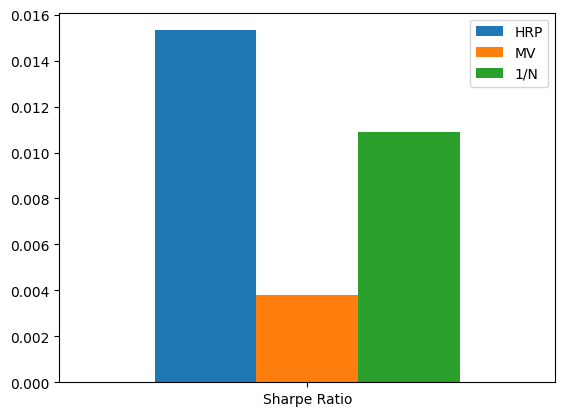

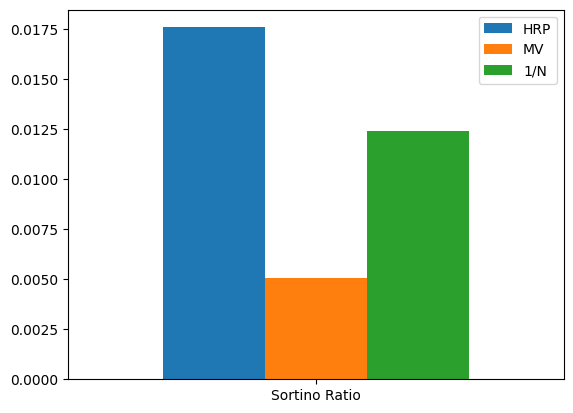

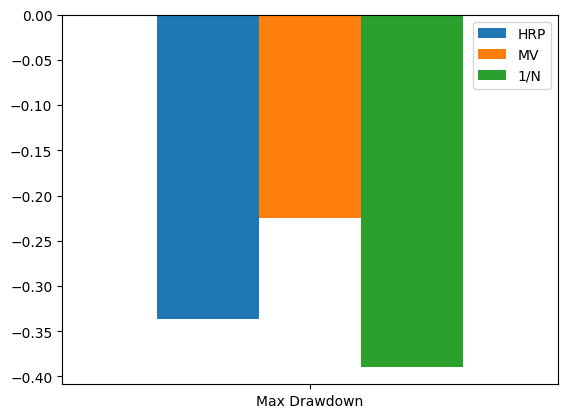

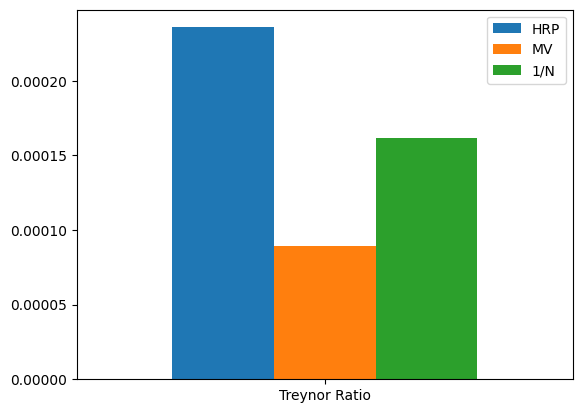

In [52]:
sr_is.T.plot(kind='bar', width=0.8, rot=0)
plt.savefig("sharpe_ratio.png", transparent=True)
sor_is.T.plot(kind='bar', width=0.8, rot=0)
plt.savefig("sortino_ratio.png", transparent=True)
maxdd_is.T.plot(kind='bar', width=0.8, rot=0)
plt.savefig("maxdd.png", transparent=True)
tr_is.T.plot(kind='bar', width=0.8, rot=0)
plt.savefig("treynor_ratio.png", transparent=True)

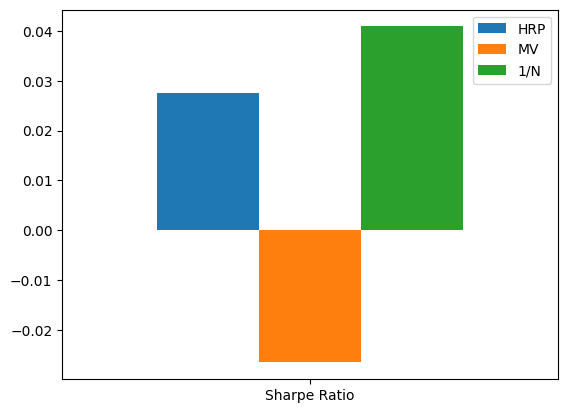

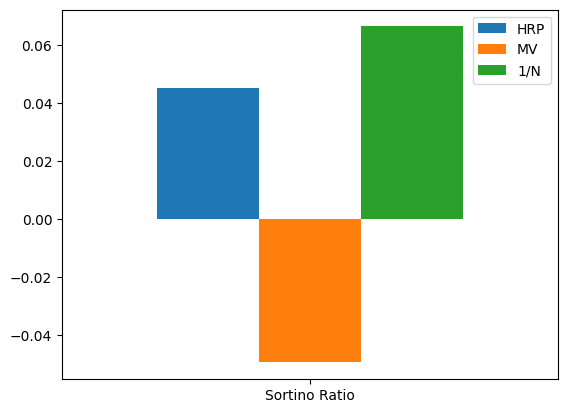

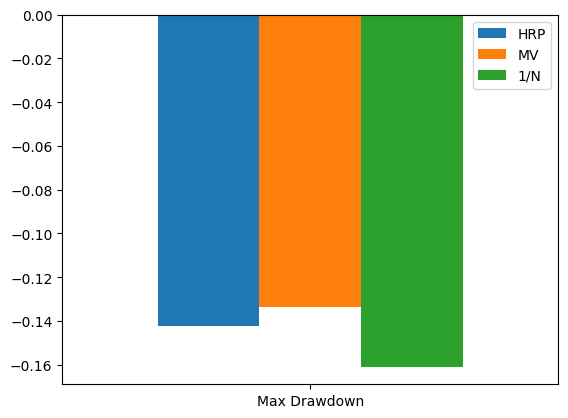

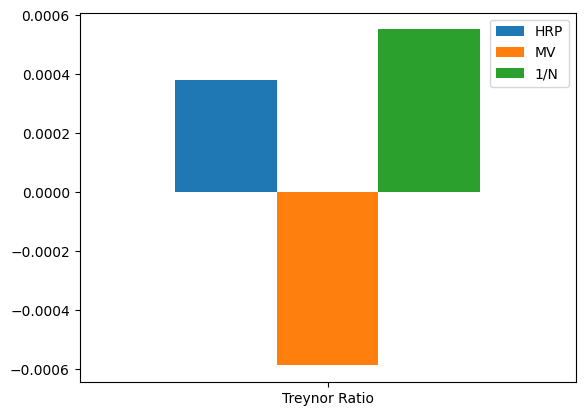

In [53]:
sr_oos.T.plot(kind='bar', width=0.8, rot=0)
plt.savefig("sharpe_ratio_os.png", transparent=True)
sor_oos.T.plot(kind='bar', width=0.8, rot=0)
plt.savefig("sortino_ratio_os.png", transparent=True)
maxdd_oos.T.plot(kind='bar', width=0.8, rot=0)
plt.savefig("maxdd_os.png", transparent=True)
tr_oos.T.plot(kind='bar', width=0.8, rot=0)
plt.savefig("treynor_ratio_os.png", transparent=True)

### Portfolio Expected Return fixed

In [54]:
def portfolio_ER(returns, weights):
    mean = returns.mean()
    return weights * mean

In [55]:
portfolio_ER(norm_return, HRP).sum()

11498.132711806995

In [56]:
ER_HRP = portfolio_ER(norm_return, HRP)
ER_HRP.name = "HRP"
ER_MV = portfolio_ER(norm_return, MV)
ER_MV.name = "MV"
ER_EW = portfolio_ER(norm_return, EW)
ER_EW.name = "1/N"
ERS = ER_HRP.to_frame()
ERS = ERS.join(ER_MV.to_frame())
ERS = ERS.join(ER_EW.to_frame())
ERS = ERS.sum()
ERS.name = "Expected Return"
ERS = ERS.to_frame()
ERS

,Expected Return
HRP,11498.132712
MV,9971.981102
1/N,11273.302462


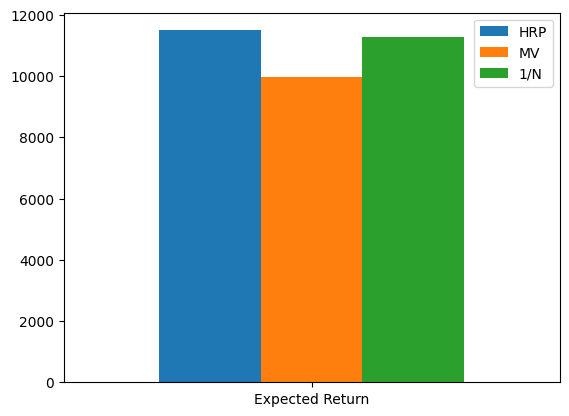

In [57]:
ERS.T.plot(kind='bar', width=0.8, rot=0);

In [58]:
real_ret = (test)[-1:].T
real_ret

Date,2022-12-30
HRP,10300.771541
MV,9679.752895
1/N,10563.464886


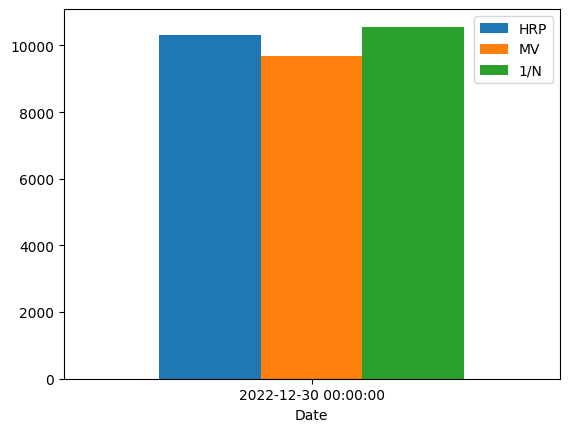

In [59]:
real_ret.T.plot(kind='bar', width=0.8, rot=0);

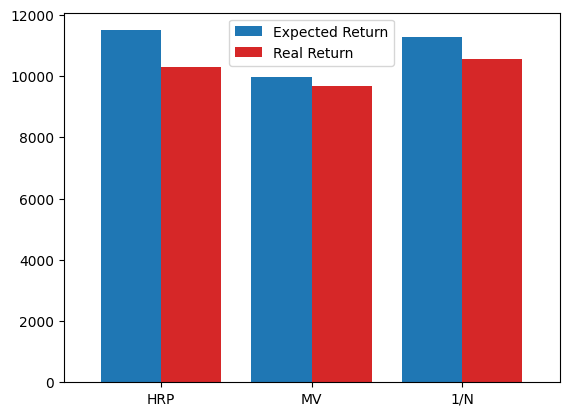

In [60]:
expected = ERS["Expected Return"].tolist()
real = real_ret['2022-12-30'].values.tolist()
index = ['HRP', 'MV', '1/N']
df = pd.DataFrame({'Expected Return': expected,
                   'Real Return': real}, index=index)
ax = df.plot.bar(width=0.8, rot=0, color={'Expected Return': "tab:blue", 'Real Return': "tab:red"})